In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json

from pendulum_ml.models.registry import make_model
from pendulum_ml.data.dataset import build_loaders
from pendulum_ml.verification.attacks import make_attack_fn
from pendulum_ml.verification import xai

run_clean = "quad_clean_config"
run_adv = "quad_adv_config"
base_path = Path("../experiments")
model_path= Path("../models/checkpoints")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/ruchiraray/miniconda3/envs/pendulum-ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model(run_id):
    run_dir = base_path / run_id
    cfg = json.loads((run_dir / "config.json").read_text())
    model = make_model(cfg["model"]["name"],
                       in_dim=cfg["model"]["in_dim"],
                       hidden=tuple(cfg["model"]["hidden"]),
                       out_dim=cfg["model"]["out_dim"]).to(device)
    ckpt = model_path / f"{run_id}.pt"
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()
    return model, cfg

model_clean, cfg_clean = load_model(run_clean)
model_adv, cfg_adv = load_model(run_adv)
print(cfg_clean)


{'seed': 42, 'device': 'cpu', 'system': 'quadcopter', 'dynamics': {'dt': 0.01, 'control_dt': 0.01, 'integrator': 'rk4', 'params': {'quad': {'mass': 1.5, 'inertia': 0.03, 'arm_length': 0.25}, 'payload': {'mass': 0.25, 'rope_length': 1.0}, 'environment': {'gravity': 9.81}, 'winch': {'model': 'algebraic', 'omega': 10.0}, 'actuators': {'max_thrust': 20.0, 'max_pitch_torque': 5.0, 'min_pitch_torque': -5.0}}}, 'controller': {'type': 'pid', 'pid': {'x': {'Kp': 8, 'Ki': 0, 'Kd': 12, 'u_min': -10.0, 'u_max': 10.0}, 'z': {'Kp': 40.0, 'Ki': 5, 'Kd': 10, 'u_min': -10.0, 'u_max': 10.0, 'setpoint': 0.0}, 'theta': {'Kp': 30, 'Ki': 0, 'Kd': 4, 'u_min': -5.0, 'u_max': 5.0}, 'phi': {'Kp': 30.0, 'Ki': 0, 'Kd': 4.0, 'u_min': -10.0, 'u_max': 10.0}, 'l': {'Kp': 0.0, 'Ki': 0.0, 'Kd': 0.0, 'u_min': 0.0, 'u_max': 0.0}}}, 'data': {'n_trajectories': 1, 'initial_state': [[-0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]], 'sim_time': 20, 'train_ratio': 0.8, 'val_ratio': 0.1, 'test_ratio': 0.1, 'standardize': Tr

In [3]:
attack_fn = make_attack_fn(method="pgd", eps=0.1, steps=40, alpha=0.0025)
loaders = build_loaders(cfg_clean)
X_test, Y_test = next(iter(loaders["test"]))
X_test, Y_test = X_test.to(device), Y_test.to(device)

x = X_test[0:1]
y = Y_test[0:1]

x_adv = attack_fn(model_clean, x, y)

with torch.no_grad():
    clean_pred = model_clean(x)
    adv_pred = model_clean(x_adv)
    robust_pred = model_adv(x_adv)

print("Clean model (clean input):", clean_pred)
print("Clean model (adv input):", adv_pred)
print("Adv-trained model (adv input):", robust_pred)


Clean model (clean input): tensor([[-2.0983e-02,  1.6094e+00, -1.5982e-02,  2.8992e-02, -2.6324e-04]])
Clean model (adv input): tensor([[ 0.0951,  1.3972, -0.0308, -0.0522, -0.0067]])
Adv-trained model (adv input): tensor([[ 0.0722,  1.5190, -0.0559, -0.0431,  0.0036]])


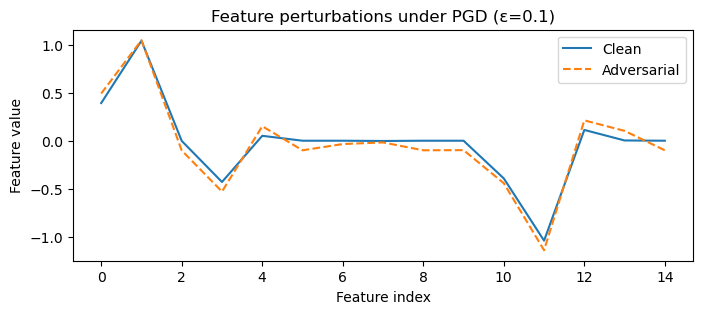

In [8]:
attack_fn = make_attack_fn(method="pgd", eps=0.1, steps=40, alpha=0.0025)

x = X_test[0:1]
y = Y_test[0:1]
x_adv = attack_fn(model_clean, x, y)

plt.figure(figsize=(8,3))
plt.plot(x.cpu().numpy().flatten(), label="Clean")
plt.plot(x_adv.cpu().numpy().flatten(), "--", label="Adversarial")
plt.title("Feature perturbations under PGD (ε=0.1)")
plt.xlabel("Feature index")
plt.ylabel("Feature value")
plt.legend()
plt.show()


In [11]:
def evaluate(model, X, Y, attack_fn):
    with torch.no_grad():
        clean_loss = torch.nn.functional.mse_loss(model(X), Y).item()
    X_adv = attack_fn(model, X, Y)
    with torch.no_grad():
        adv_loss = torch.nn.functional.mse_loss(model(X_adv), Y).item()
    return clean_loss, adv_loss

epsilons = [0.01, 0.05, 0.1, 0.2]
steps = [10, 20, 40]
results = []

for eps in epsilons:
    for s in steps:
        attack = make_attack_fn("pgd", eps=eps, steps=s, alpha=eps/s)
        loss_clean, loss_adv_clean = evaluate(model_clean, X_test, Y_test, attack)
        loss_clean_adv, loss_adv_adv = evaluate(model_adv, X_test, Y_test, attack)
        results.append((eps, s, loss_clean, loss_adv_clean, loss_clean_adv, loss_adv_adv))

import pandas as pd
df = pd.DataFrame(results, columns=["eps", "steps", "clean_loss", "adv_loss_clean", "clean_loss_adv","adv_loss_adv"])
df


,eps,steps,clean_loss,adv_loss_clean,clean_loss_adv,adv_loss_adv
0,0.01,10,0.003986,0.005310,0.002142,0.002659
1,0.01,20,0.003986,0.005280,0.002142,0.002753
2,0.01,40,0.003986,0.005282,0.002142,0.002766
3,0.05,10,0.003986,0.013882,0.002142,0.007680
4,0.05,20,0.003986,0.015979,0.002142,0.006149
5,0.05,40,0.003986,0.014567,0.002142,0.006239
6,0.10,10,0.003986,0.036524,0.002142,0.017226
7,0.10,20,0.003986,0.038417,0.002142,0.015898
8,0.10,40,0.003986,0.036858,0.002142,0.015714
9,0.20,10,0.003986,0.134804,0.002142,0.059119


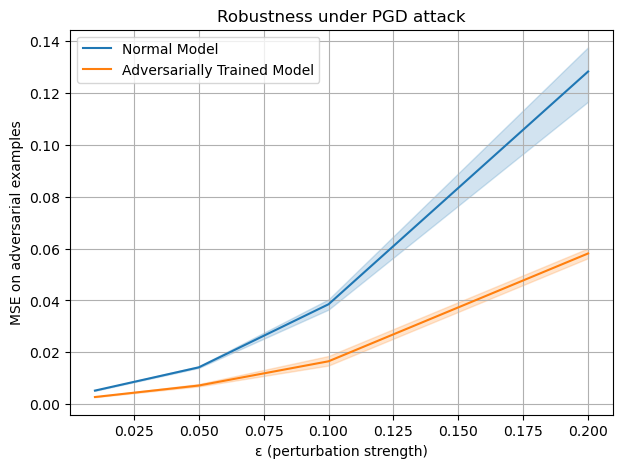

In [10]:
import seaborn as sns
plt.figure(figsize=(7,5))
sns.lineplot(data=df, x="eps", y="adv_loss_clean", label="Normal Model")
sns.lineplot(data=df, x="eps", y="adv_loss_adv", label="Adversarially Trained Model")
plt.title("Robustness under PGD attack")
plt.xlabel("ε (perturbation strength)")
plt.ylabel("MSE on adversarial examples")
plt.legend()
plt.grid(True)
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


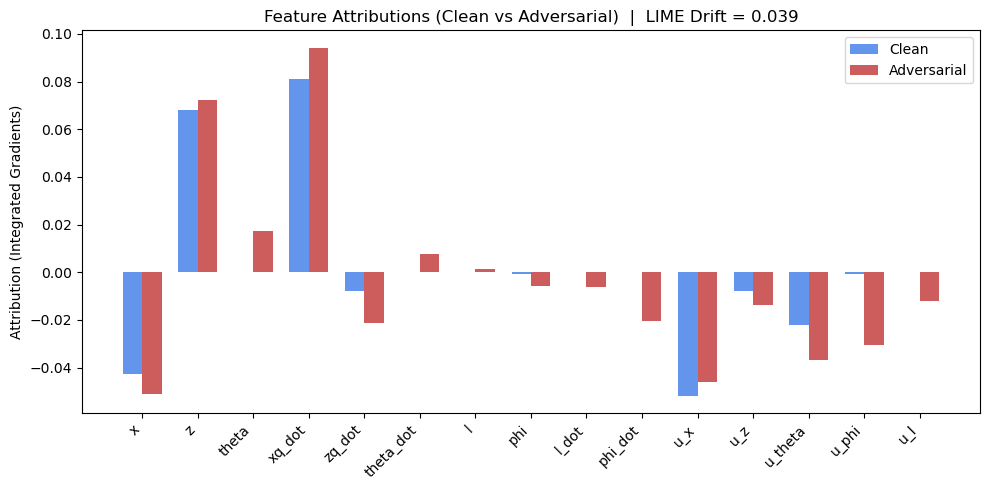

In [12]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = cfg_clean["features"][:15]

# --- LIME drift computation ---
explainer = xai.explain_lime(model_clean, X_test[:100].detach().cpu(), feature_names)
exp_clean = xai.lime_explain_instance(model_clean, explainer, x[0], output_idx=0)
exp_adv   = xai.lime_explain_instance(model_clean, explainer, x_adv[0], output_idx=0)
drift = xai.attribution_drift(exp_clean, exp_adv)
print(f"LIME Drift: {drift:.4f}")

# --- Integrated Gradients for both clean & adv ---
attrs_clean, _ = xai.integrated_gradients(model_clean, x, target=0)
attrs_adv, _   = xai.integrated_gradients(model_clean, x_adv, target=0)

vals_clean = attrs_clean.cpu().numpy().flatten()
vals_adv   = attrs_adv.cpu().numpy().flatten()

# --- Combined bar chart ---
x_idx = np.arange(len(feature_names))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x_idx - width/2, vals_clean, width, label="Clean", color="cornflowerblue")
plt.bar(x_idx + width/2, vals_adv,   width, label="Adversarial", color="indianred")

plt.xticks(x_idx, feature_names, rotation=45, ha="right")
plt.ylabel("Attribution (Integrated Gradients)")
plt.title(f"Feature Attributions (Clean vs Adversarial)  |  LIME Drift = {drift:.3f}")
plt.legend()
plt.tight_layout()
plt.show()
